1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [242]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from catboost import CatBoostClassifier

from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder


from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin



In [243]:
df = pd.read_csv('data.csv')

In [244]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [245]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)

In [246]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
treatment        64000 non-null object
target           64000 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [248]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [249]:
df["treatment"] = df['treatment'].replace('Buy One Get One', 1).replace('Discount', 1).replace('No Offer', 0)

In [250]:
df['treatment'].unique()

array([1, 0])

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
treatment        64000 non-null int64
target           64000 non-null int64
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [252]:
df_train_index, df_test_index = train_test_split(df.index, test_size=0.3, random_state=23)

In [253]:
num_cols = ['recency', 'history']
scaler = StandardScaler()
for col in num_cols:
        df[col] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df[col])),columns=[col])

cat_features = ['zip_code', 'channel']   

In [254]:
df_features = df.copy()
df_features.drop('treatment', 1).drop('target', 1)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
0,1.207751,-0.389003,1,0,Surburban,0,Phone
1,0.067359,0.339614,1,1,Rural,1,Web
2,0.352457,-0.239836,0,1,Surburban,1,Web
3,0.922653,1.693278,1,0,Rural,1,Web
4,-1.073034,-0.768068,1,0,Urban,0,Web
...,...,...,...,...,...,...,...
63995,1.207751,-0.533055,1,0,Urban,0,Web
63996,-0.217739,-0.793170,0,1,Urban,1,Phone
63997,0.067359,-0.827992,1,0,Urban,1,Phone
63998,-1.358132,1.213532,1,0,Surburban,1,Multichannel


In [255]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,1.207751,-0.389003,1,0,Surburban,0,Phone,1,0
1,0.067359,0.339614,1,1,Rural,1,Web,0,0
2,0.352457,-0.239836,0,1,Surburban,1,Web,1,0
3,0.922653,1.693278,1,0,Rural,1,Web,1,0
4,-1.073034,-0.768068,1,0,Urban,0,Web,1,0


In [256]:
df.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [257]:
X_train = df_features.loc[df_train_index, :]
y_train = df.loc[df_train_index, 'target']
treat_train = df.loc[df_train_index, 'treatment']

X_val = df_features.loc[df_test_index, :]
y_val = df.loc[df_test_index, 'target']
treat_val =  df.loc[df_test_index, 'treatment']

models_results_10 = {
    'approach': [],
    'uplift@10%': []
}

models_results_20 = {
    'approach': [],
    'uplift@20%': []
}

In [258]:
X_val.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
44433,1.207751,-0.335910,0,1,Urban,1,Phone,1,0
44668,0.352457,-0.645838,1,0,Surburban,1,Web,1,0
47303,-1.358132,-0.040310,1,1,Surburban,0,Phone,0,1
23627,-1.358132,-0.827992,1,0,Urban,0,Web,1,0
14419,1.207751,0.801714,0,1,Urban,1,Multichannel,0,0
50519,-0.217739,-0.591379,0,1,Surburban,0,Web,1,0
36656,0.067359,0.500102,0,1,Urban,0,Web,1,0
19312,-1.358132,0.175652,0,1,Surburban,1,Web,1,0
3792,-0.502837,0.011026,0,1,Rural,0,Phone,1,0
18492,-0.502837,0.833218,1,1,Rural,0,Phone,1,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f28433990>,
      dtype=object)

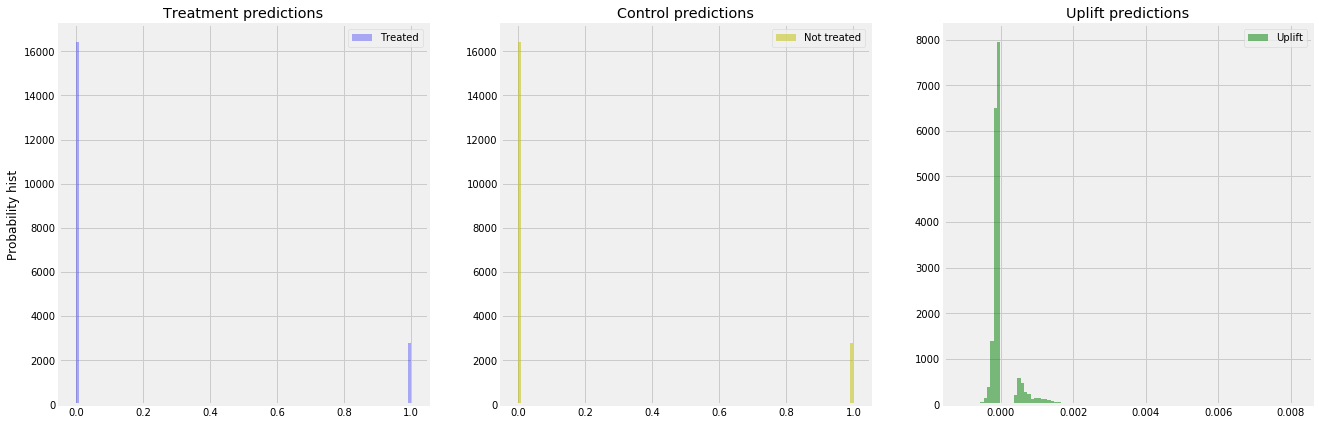

In [259]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results_10['approach'].append('SoloModel')
models_results_10['uplift@10%'].append(sm_score_10)

sm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results_20['approach'].append('SoloModel')
models_results_20['uplift@20%'].append(sm_score_20)

plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_)

In [260]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results_10['approach'].append('ClassTransformation')
models_results_10['uplift@10%'].append(ct_score_10)

ct_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results_20['approach'].append('ClassTransformation')
models_results_20['uplift@20%'].append(ct_score_20)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8f2dbec290>,
      dtype=object)

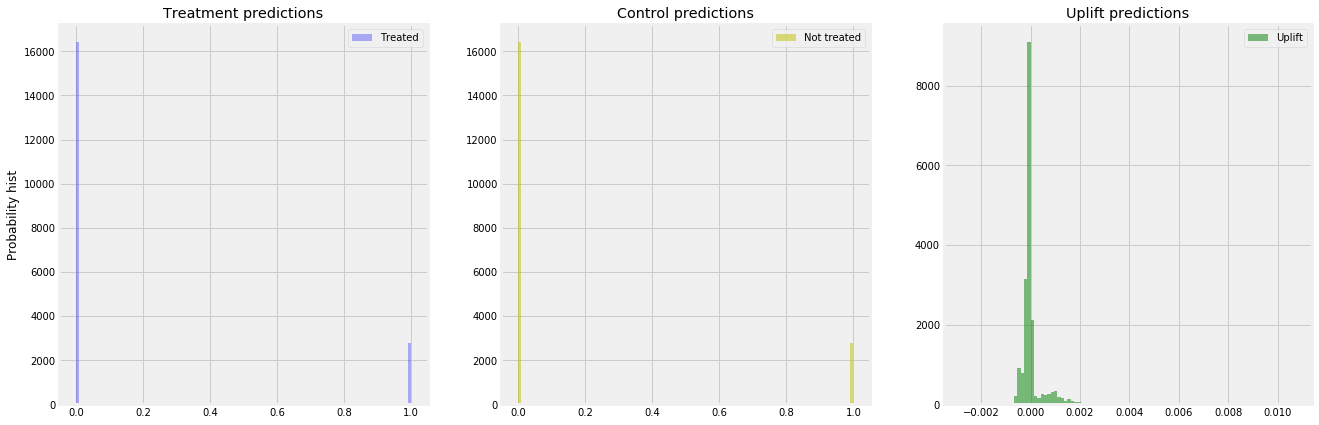

In [261]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score_10 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results_10['approach'].append('TwoModels')
models_results_10['uplift@10%'].append(tm_score_10)

tm_score_20 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)

models_results_20['approach'].append('TwoModels')
models_results_20['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [262]:
pd.DataFrame(data=models_results_10).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%
0,SoloModel,0.0
1,ClassTransformation,0.0
2,TwoModels,0.0


In [263]:
pd.DataFrame(data=models_results_20).sort_values('uplift@20%', ascending=False)

,approach,uplift@20%
0,SoloModel,0.295969
1,ClassTransformation,0.295969
2,TwoModels,0.295969


In [264]:
cat_features = ['zip_code', 'channel']  

X_train_tree = pd.concat([X_train.drop(cat_features, 1),
                          pd.get_dummies(X_train, prefix=['zip_code', 'channel'])], 1)

features = [col for col in X_train_tree]

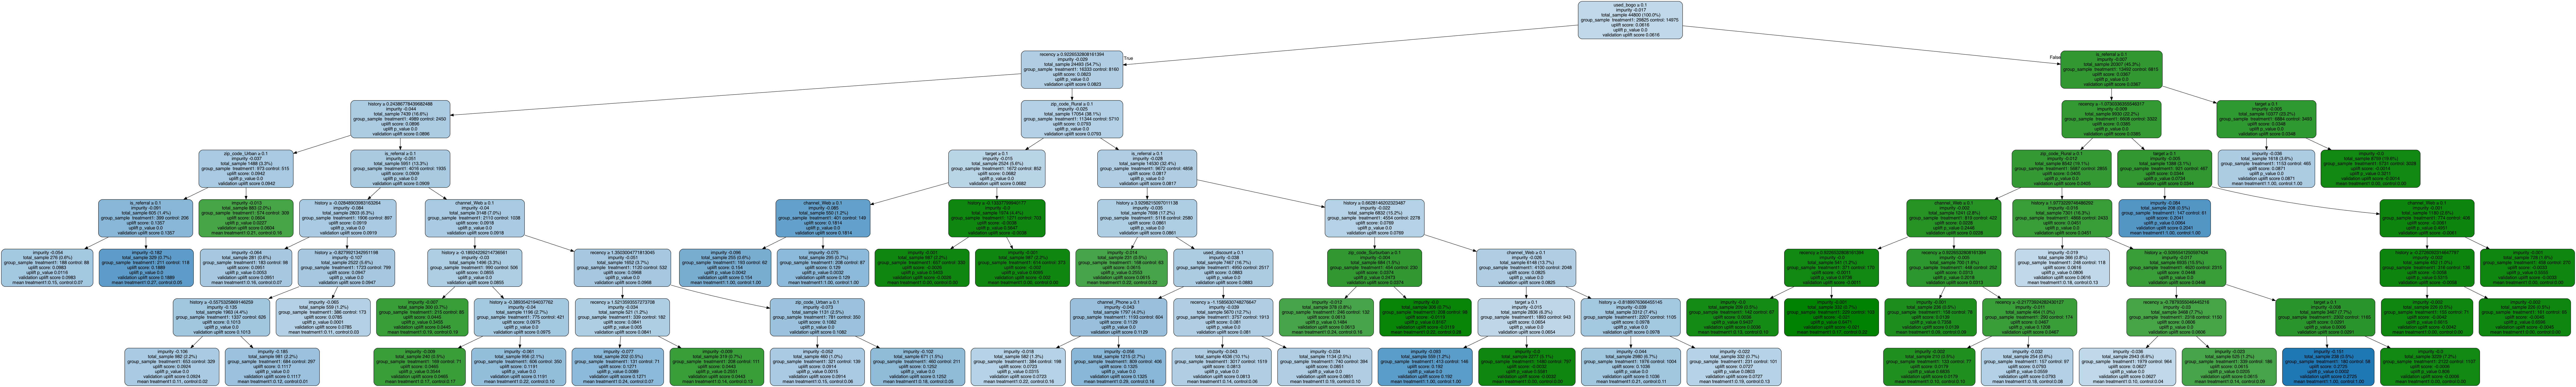

In [269]:
uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())